<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GCCE/fft_western_gcce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiscale Permutation Entropy using feature relevance analysis for vibration-based condition monitoring

## Case Western Reserve Experiments

Database link: https://engineering.case.edu/bearingdatacenter

Vibration signals were collected according to the following conditions (classes): i) Normal bearing (Nor), fault in the internal train (IR1), fault in the external train (IR2), and fault in the rolling element-ball (BE). Moreover, the failure states were produced with three levels of severity (0.007′′, 0.014′′, and 0.021′′) and three operating speeds (1730, 1750, 1772, and 1797 [rpm]). Each experiment was repeated three times, and the data was collected at 12 kHz for 5 seconds. Each signal was divided into ten sub-signals. 

Accordingly, $F_s=12k$ [Hz], $N = 1200$, $T = 4096$, $C = 10$.

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        # p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        # temp1 = ann_*tf.math.log(p_logreg)  
        # temp2 = (1 - ann_)*tf.math.log(1/K)*tf.reduce_sum(Y_true,axis=1)
        # aux = tf.repeat(tf.reduce_sum(pred*tf.math.log(pred),axis=1,keepdims=True), R, axis = 1)
        # tf.print(tf.shape(aux))
        # print(tf.shape(aux))
        # temp2 = (1 - ann_)*aux*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        # Y_true_1 = tf.clip_by_value(Y_true, clip_value_min=1e-9, clip_value_max=1)
        # p_logreg_inv = tf.math.reduce_prod(tf.math.pow(Y_true_1, Y_hat), axis=1)
        # temp2 = (1 - ann_)*tf.math.log(p_logreg_inv) 
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

    def custom_RCDNN_loss(self, y_true, y_pred):  #ytrue \in N x R,  ypred \in N x (R+K) -> PRI->JULI
    
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 

        #Ground truth estimation samples (N) x  Classes(K)
        pred = y_pred[:,self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
        # Annotators reliability prediction: samples (N) x  annotators (R)
        ann_ = y_pred[:,:self.R]
        #Y_true 1-K: samples (N) x  Classes(1-K), annotators (R)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
        #loss computation
        p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        temp1 = ann_*tf.math.log(p_logreg)  
        temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        return -tf.math.reduce_sum((temp1 + temp2))

    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(200,activation='selu',name='h1',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(50,activation='selu',name='h2',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        output_R = tf.keras.layers.Dense(self.R,activation="sigmoid", 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_R_GCCE' )(dout)
 
        output_K = tf.keras.layers.Dense(self.K,activation="softmax", 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_K_GCCE')(dout)
 
        output = tf.keras.layers.concatenate([output_R, output_K])
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=self.GCCE_MA_loss, optimizer=opt)
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
    
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


In [2]:
import random
import warnings
import numpy as np
#import climin
from functools import partial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


#Defining the Sigmoid function and Softmax function
def Sigmoid(f_r):
    lam_r = 1/(1 + np.exp(-f_r))
    return lam_r

def MAjVot(Y, K):
    N,R = Y.shape
    Yhat = np.zeros((N,1))
    for n in range(N):
        votes = np.zeros((K,1))
        for r in range(R):
            for k in range(K):
                if Y[n,r] == k+1:
                    votes[k] = votes[k]+1
        Yhat[n] = np.argmax(votes) + 1
    return Yhat


def  MA_Clas_Gen(Xtrain,ytrain,R,NrP):

    N = len(ytrain)
    K = len(np.unique(ytrain))
    Kn = np.unique(ytrain)
    aux = 0
    A = np.zeros((K,1))
    for k in Kn:
        A[aux] = (ytrain == k).sum()
        aux = aux + 1
    per = np.min(A)
    if N < 25000:
        Xtrain = TSNE(n_components=1,perplexity=per/2).fit_transform(Xtrain)
    else:
        Xtrain = np.sum(Xtrain,1)
    # Xtrain = Xtrain-Xtrain.min()
    # Xtrain = Xtrain/Xtrain.max()
    #ytrain = y
    # scaler = StandardScaler()
    # scalerY = scaler.fit(y)
    # ytrain = scaler.fit_transform(y)

    
    #miny = y.min()
    #ytrain = y-miny
    #maxy = ytrain.max()
    #ytrain = ytrain/maxy
  
    # Xtrain = np.sum(Xtrain, axis=1)
    Xtrain = Xtrain - Xtrain.min()
    #print(Xtrain.min(), Xtrain.max())
    Xtrain = Xtrain/Xtrain.max()
    Xtrain = Xtrain.reshape((N,1))
    yprueba = np.ones((N,1))
    
    
    u_q = np.empty((Xtrain.shape[0],3))
    u_q[:,0,None] = 4.5*np.cos(2*np.pi*Xtrain + 1.5*np.pi) - \
                               3*np.sin(4.3*np.pi*Xtrain + 0.3*np.pi)
                    
    u_q[:,1,None] = 4.5*np.cos(1.5*np.pi*Xtrain + 0.5*np.pi) + \
                       5*np.sin(3*np.pi*Xtrain + 1.5*np.pi)
    
    u_q[:,2,None] = 1
    
    W = []
    # q=1
    Wq1 = np.array(([[0.4],[0.7],[-0.5],[0],[-0.7]]))
    W.append(Wq1)
    # q=2
    Wq2 = np.array(([[0.4],[-1.0],[-0.1],[-0.8],[1.0]]))
    W.append(Wq2)
    Wq3 = np.array(([[3.1],[-1.8],[-0.6],[-1.2],[1.0]]))
    W.append(Wq3)

    
    F_r = []
    Lam_r = []
    for r in range(R):
        f_r = np.zeros((Xtrain.shape[0], 1))
        # rho_r = np.zeros((Xtrain.shape[0], 1))
        for q in range(3):
            f_r += W[q][r].T*u_q[:,q,None]
        F_r.append(f_r)
        lam_r = Sigmoid(f_r)
        lam_r[lam_r>0.5] = 1
        lam_r[lam_r<=0.5] = 0
        Lam_r.append(lam_r)
    plt.plot(Xtrain,Lam_r[2],'rx')
    plt.show()
    seed = 0
    np.random.seed(seed)
    Ytrain = np.ones((N, R))
    for r in range(R):
        aux = ytrain.copy()
        for n in range(N):
            if Lam_r[r][n] == 0:
                labels = np.arange(1, K+1)
                a = np.where(labels==ytrain[n])
                labels = np.delete(labels, a)
                idxlabels = np.random.permutation(K-1)
                aux[n] = labels[idxlabels[0]]         
        Ytrain[:,r] = aux.flatten()
        
   # Ytrain = (Ytrain*maxy) + miny
        
    iAnn = np.zeros((N, R), dtype=int) # this indicates if the annotator r labels the nth sample.
    Nr = np.ones((R), dtype=int)*int(np.floor(N*NrP))  
    for r in range(R):
        if r < R-1:
            indexR = np.random.permutation(range(N))[:Nr[r]]
            iAnn[indexR,r] = 1
        else:
            iSimm = np.sum(iAnn, axis=1)
            idxZero = np.asarray([i for (i, val) in enumerate(iSimm) if val == 0])
            Nzeros = idxZero.shape[0]
            idx2Choose = np.arange(N)
            if Nzeros == 0:
                indexR = np.random.permutation(range(N))[:Nr[r]]
                iAnn[indexR,r] = 1
            else:
                idx2Choose = np.delete(idx2Choose, idxZero)
                N2chose = idx2Choose.shape[0]
                idxNoZero = np.random.permutation(N2chose)[:(Nr[r] - Nzeros)]
                idxTot = np.concatenate((idxZero, idx2Choose[idxNoZero]))
                iAnn[idxTot,r] = 1
    
    # Now, we verify that all the samples were labeled at least once
    Nr = (np.sum(iAnn,0))
    iSimm = np.sum(iAnn, axis=1)
    if np.asarray([i for (i, val) in enumerate(iSimm) if val == 0]).sum() == 0:
        ValueError("all the samples must be labeled at least once")

    # Finally, if iAnn=0 we assign a reference value to indicate a missing value
    Vref = -1e-20
    for r in range(R):
        Ytrain[iAnn[:,r] == 0, r] = Vref 

    return Ytrain, iAnn, Lam_r


def CrossVal(X, pp, Nk):
    N = X.shape[0]
    Ntr = int(N*pp)
    Nte = N - Ntr
    idxtr = np.zeros((Ntr,Nk))
    idxte = np.zeros((Nte,Nk))
    
    for i in range(Nk):
        index = np.random.permutation(range(N))
        idxtr[:,i] = index[:Ntr]
        idxte[:,i] = index[Ntr:]
        
    return idxtr, idxte
    

In [3]:
#data downloaded for google drive
FILEID = "1IC11LrPCZIo_Am5eXP2p2tDAlrGTlPjn"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O datos.zip && rm -rf /tmp/cookies.txt
!unzip -o datos.zip
!dir
database = 'Western'

--2022-12-18 05:01:44--  https://docs.google.com/uc?export=download&confirm=t&id=1IC11LrPCZIo_Am5eXP2p2tDAlrGTlPjn
Resolving docs.google.com (docs.google.com)... 172.217.204.100, 172.217.204.102, 172.217.204.113, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2utt7ibiso3m6746c99bihsk9n1ruauv/1671339675000/09173029842254050324/*/1IC11LrPCZIo_Am5eXP2p2tDAlrGTlPjn?e=download&uuid=93cec38f-8a59-47f4-aa84-d3c4e3a4b5e9 [following]
--2022-12-18 05:01:44--  https://doc-10-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2utt7ibiso3m6746c99bihsk9n1ruauv/1671339675000/09173029842254050324/*/1IC11LrPCZIo_Am5eXP2p2tDAlrGTlPjn?e=download&uuid=93cec38f-8a59-47f4-aa84-d3c4e3a4b5e9
Resolving doc-10-0s-docs.googleusercontent.com (doc-10-0s-docs.googleusercontent.com)... 172.217.203.

In [4]:
#main libraries and functions
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import warnings
#compute centroid index 
from sklearn.metrics import pairwise_distances
import matplotlib

warnings.filterwarnings('ignore')


def centroid_(X):
  mean_X = X.mean(axis=0)#computing mean along samples
  D = pairwise_distances(mean_X.reshape(1,-1),X)
  return np.argmin(D)#return centroid index


#loading data
path_ = 'CaractCE.mat'#Case Western Database
dicX = sio.loadmat(path_)

In [5]:
dicX.keys()


dict_keys(['__header__', '__version__', '__globals__', 'CE', 'E', 'F'])

In [6]:
Xt = dicX['F'] #time segments
Fs = 12000 #sampling frequency
Tl = Xt.shape[1]/Fs
print('Xt shape:',Xt.shape)
print('Time length [s]', Tl)

Xt shape: (1200, 4000)
Time length [s] 0.3333333333333333


Multiscale permutation entropy was calculated for each time segment, fixing the delay within [xx,xx] and the embedding time within the range [xx,xxx]. See MPEVA.py for details.

## Loading MPE features, time segments, and labels

In [7]:
#loading precalculated MPE features
X = dicX['CE']
print('MPE feature matriz shape:',X.shape)

MPE feature matriz shape: (1200, 125)


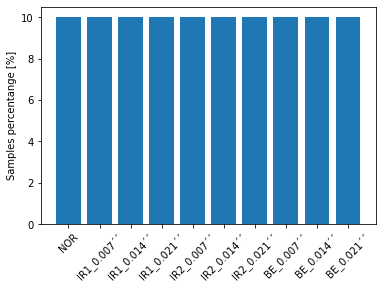

In [8]:
Y = dicX['E']
Ytrue = Y[:,2] #target classes

labels_ = ['NOR','IR1_0.007´´','IR1_0.014´´','IR1_0.021´´',
           'IR2_0.007´´','IR2_0.014´´','IR2_0.021´´',
           'BE_0.007´´','BE_0.014´´','BE_0.021´´'
           ] #classes name

#histogram
unique_elements, counts_elements = np.unique(Ytrue, return_counts=True)
plt.bar(unique_elements,100*counts_elements/X.shape[0])
plt.xticks(unique_elements)
plt.ylabel('Samples percentange [%]')
plt.gca().set_xticklabels(labels_,rotation=45)
plt.show()

In [9]:
#rpm labels
nrpm = 30
Yrpm_b = np.r_[0*np.ones(nrpm),np.ones(nrpm),2*np.ones(nrpm),3*np.ones(nrpm)]
Yrpm_b.shape
Yrpm = Yrpm_b
for i in range(len(labels_)-1):
  Yrpm = np.r_[Yrpm,Yrpm_b]



In [10]:
Y = np.c_[Y,Yrpm]

In [11]:
import joblib

CaseWestern_data = {'Xdata_time' : Xt, 'Fs' : Fs,
                    'Xdata_MPE' : X, 'Y_labels' : Y}

joblib.dump(CaseWestern_data,"CasaWestern_data.pkl")

['CasaWestern_data.pkl']

In [12]:
Y.shape

(1200, 4)

In [13]:
Y

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.],
       ...,
       [ 1.,  3., 10.,  3.],
       [ 1.,  3., 10.,  3.],
       [ 1.,  3., 10.,  3.]])

# Interpretability results

In [14]:
Xt.shape

(1200, 4000)

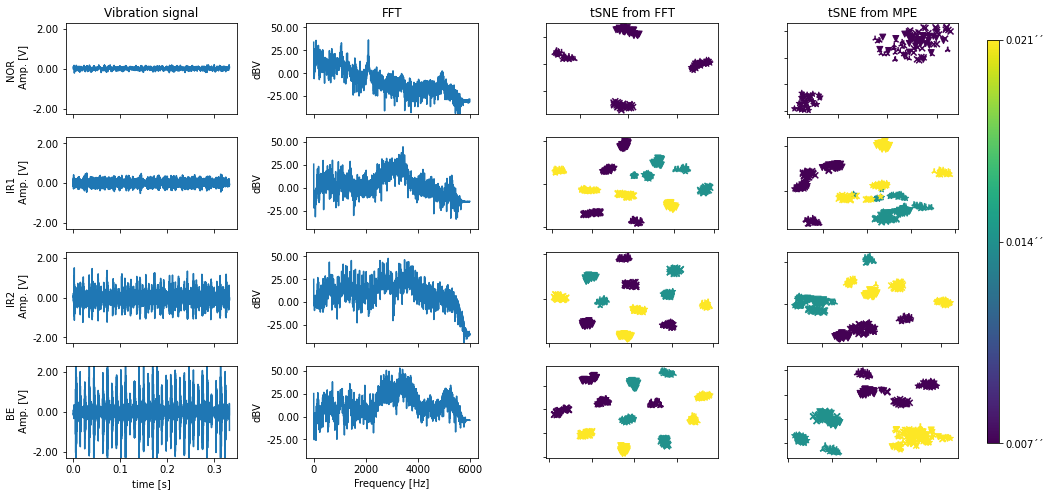

In [15]:
#scatter plots
scar = StandardScaler()
sca = MinMaxScaler()
red = TSNE(perplexity = 10,n_components=2,random_state=123)
vt = np.arange(0,Tl,1/Fs)
Ytrue_f = Y[:,1] # labels = [Normal, Internal, External, Ball]
labels_f = ['NOR', 'IR1', 'IR2', 'BE']
#scatter along fault lables
fig, axs = plt.subplots(len(labels_f),4,figsize=(16, 8))
j=0
vf = np.fft.rfftfreq(Xt.shape[1],1/Fs) #freq vector
Xw = 20*np.log10(abs(np.fft.rfft(Xt))) # FFT

marker_s = ['2','v','x','*'] # RPM1, RPM2, RPM3, RPM4 as marker changes

for i in np.unique(Ytrue_f):
  X_ = Xt[Ytrue_f==i]
  Xw_ = Xw[Ytrue_f==i]
  XE_ = X[Ytrue_f==i]
  Z_ = scar.fit_transform(red.fit_transform(sca.fit_transform(Xw_)))
  Z_e = scar.fit_transform(red.fit_transform(sca.fit_transform(XE_)))
   
  #identify centroid RPM1 
  ind = centroid_(Z_[Yrpm[Ytrue_f==i] == 0])
  #time plots
  axs[j,0].plot(vt,X_[ind])
  axs[j,0].set_ylim([-2.3,2.3])
  axs[j,0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  axs[j,0].set_ylabel(labels_f[j]+' \n Amp. [V]')
  if j!=len(labels_f)-1: axs[j,0].set_xticklabels([])

  #frequency plots
  axs[j,1].plot(vf,Xw_[ind])
  axs[j,1].set_ylim([-45,55])
  axs[j,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  axs[j,1].set_ylabel('dBV')
  if j!=len(labels_f)-1: axs[j,1].set_xticklabels([])

  #scatter plots
  cc = Ytrue[Ytrue_f==i]
  #FFT-based features scatter plot
  for ii in np.unique(Yrpm): 
      ind_ = Yrpm[Ytrue_f==i] == ii
      im = axs[j,2].scatter(Z_[ind_,0],Z_[ind_,1],c=cc[ind_],marker=marker_s[int(ii)])
      #axs[j,2].scatter(Z_[ind,0],Z_[ind,1],c='r',marker='v')
      axs[j,2].set_xticklabels([])
      axs[j,2].set_yticklabels([])

      #MPE-based features scatter plot
      im = axs[j,3].scatter(Z_e[ind_,0],Z_e[ind_,1],c=cc[ind_],marker=marker_s[int(ii)])
      #axs[j,3].scatter(Z_e[ind,0],Z_e[ind,1],c='r',marker='v')
      axs[j,3].set_xticklabels([])
      axs[j,3].set_yticklabels([])
  j+=1

cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
norm = matplotlib.colors.Normalize(vmin=0,vmax=2)
sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm,cax=cax,ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['0.007´´', '0.014´´', '0.021´´'])

axs[-1,0].set_xlabel('time [s]')
axs[-1,1].set_xlabel('Frequency [Hz]')  
axs[0,0].set_title('Vibration signal')
axs[0,1].set_title('FFT')
axs[0,2].set_title('tSNE from FFT')
axs[0,3].set_title('tSNE from MPE')


fig.subplots_adjust(wspace=0.4, hspace=0.25)
plt.show()



In [16]:
#X.shape

In [17]:
Ytrue.min()
#X = Xw


1

In [18]:
X.shape

(1200, 125)

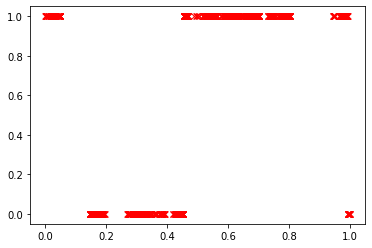

In [19]:
Y, iAnn, Lam_r = MA_Clas_Gen(X ,Ytrue, R=5, NrP=1)

In [20]:
Y = Y - 1
t = Ytrue- 1

annotator 1
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       120
           1       0.83      1.00      0.91       120
           2       0.61      0.21      0.31       120
           3       0.85      0.90      0.87       120
           4       0.50      0.12      0.19       120
           5       0.82      0.99      0.89       120
           6       0.87      0.97      0.92       120
           7       0.80      1.00      0.89       120
           8       0.84      1.00      0.91       120
           9       0.86      1.00      0.93       120

    accuracy                           0.82      1200
   macro avg       0.78      0.82      0.77      1200
weighted avg       0.78      0.82      0.77      1200

annotator 2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.71      1.00      0.83       120
           2       0.68      0.84      0.75       120


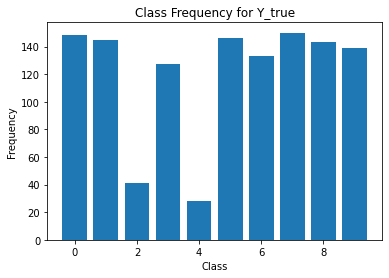

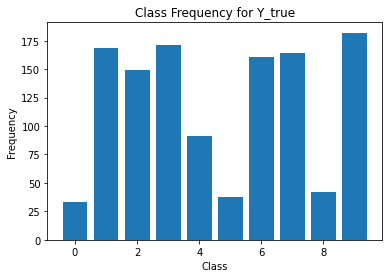

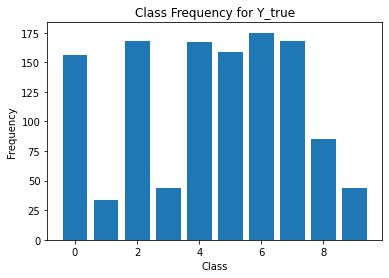

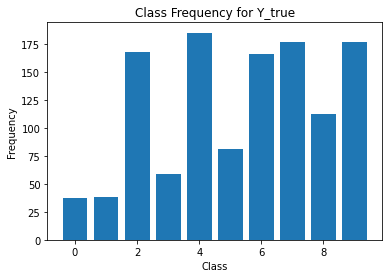

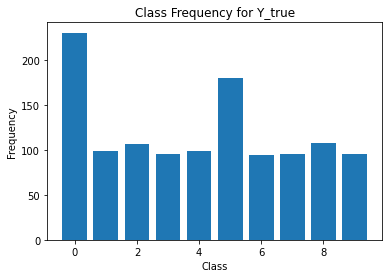

In [21]:
import pandas as pd
from sklearn.metrics import classification_report
for i in range(Y.shape[1]):
    print('annotator',i+1)
    print(classification_report(t,Y[:,i]))
    unique, counts = np.unique(Y[:,i], return_counts=True)
    plt.figure()
    plt.bar(unique, counts)
#     unique, counts = np.unique(Y_test[5], return_counts=True)
#     plt.bar(unique, counts)

    plt.title('Class Frequency for Y_true')
    plt.xlabel('Class')
    plt.ylabel('Frequency')


In [22]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:],Y[train_index,:], Y[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape, Y_train.shape, Y_true_train.shape)

[ 156  920  971  897   35  599  567  553  891 1010  524  440 1141  579
  138  566 1186  172  961  610  662  186  134  418  427  245  571  226
  348 1071  637  203 1136  210  701  879  314  448 1088  406  375 1011
  972  694  167  654 1069  678  982 1026  591 1195 1105  690  528  800
  987  568  935   42  476  693  758  486   97  299  746  305    5  490
  336  310  600  968  511  565   72  587  702  656   18   13  774  807
  960  895  802 1117 1044  279  664   67  512  921  136 1157  150 1085
   69  923  384 1106  964  456  825  204  318  196  362  887  417   85
 1051  278  209  499 1019  154  779  844  351  739   98  560  462   86
   45  590  304  228  898  332  103  882  688  429  178  319 1043  822
 1182  294  188  943  229 1114   68  177  621  677 1123  507  376 1007
  787  810  141  756 1033  163  120  240  976  252   95  529  352  431
  617  309  437  870  161  902  772  627  681  266  861  206  909  725
  221 1130 1116 1148  801  768  948  580  754  805 1119  373  973  594
  839 

In [23]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
from sklearn.metrics import classification_report

l1 =0.01
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=64,R=5, K=len(np.unique(Y_true_train)), dropout=0.25, learning_rate=0.01,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.01)

    MA.fit(X_train, Y_train)
    #MA.plot_history()
  
    #Accuracy
    pred_2 = MA.predict(X_test)
 
    report = classification_report( pred_2[:,Y.shape[1]:].argmax(axis=1),Y_true_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    #AUC
    val_AUC_metric = tf.keras.metrics.AUC(num_thresholds=3, from_logits = True)  
    val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, val_logits[:,Y.shape[1]:].argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    
  

iteration: 0
12/12 [==============================] - 0s 2ms/step
Validation aUc: 1.0000
iteration: 1
12/12 [==============================] - 0s 2ms/step
Validation aUc: 1.0000
iteration: 2
12/12 [==============================] - 0s 2ms/step
Validation aUc: 0.7857
iteration: 3
12/12 [==============================] - 0s 2ms/step
Validation aUc: 1.0000
iteration: 4
12/12 [==============================] - 0s 2ms/step
Validation aUc: 1.0000
iteration: 5
12/12 [==============================] - 0s 2ms/step
Validation aUc: 1.0000
iteration: 6
12/12 [==============================] - 0s 2ms/step
Validation aUc: 1.0000
iteration: 7
12/12 [==============================] - 0s 2ms/step
Validation aUc: 1.0000
iteration: 8
12/12 [==============================] - 0s 2ms/step
Validation aUc: 1.0000
iteration: 9
12/12 [==============================] - 0s 2ms/step
Validation aUc: 1.0000


In [25]:

ACC

array([0.98888889, 0.98611111, 0.925     , 0.97222222, 0.95833333,
       0.97777778, 0.98333333, 0.96388889, 0.975     , 0.97777778])

In [26]:

AUC

array([1.        , 1.        , 0.78571427, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [27]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)

Average Accuracy:  97.08
Average std:  1.77


In [28]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

Average Accuracy:  97.86
Average std:  6.43
